In [5]:
import heavyai
import json
import pandas as pd
from config import conf
import numpy as np
from utils import *
import ast

In [6]:
def create_connection() -> heavyai.Connection:
    con = heavyai.connect(user=conf["USER"], password=conf["PASSWORD"], host=conf["HOST"], dbname=conf["DBNAME"])
    return con
con = create_connection()

In [7]:
sites = pd.read_sql(    f"select  * from Joined_Chicago_Cell_Data_Population_Summary  ",
    con,) 
sites

,SiteID,SectorID,height_in_m,antenna_model,Downtilt,Tx_id,NBR_Cell_Name,Latitude,Longitude,Traffic_Flag,Avg_Traffic,Max_Traffic,azimuth,rf_source_id,total_population,count_excellent_quality,count_good_quality,count_fair_quality,count_poor_quality,avg_elevation_amsl_meters
0,CHCHI00893A,n71_G_1,37.490398,MX08FRO665-21,2.0,CHCHI00893A_n71_G_1,CHCHI00893A_1_n71_G,41.917496,-87.635971,Yes,11.74,20.67,45,CHCHI00893A_n71_G_1,9052.556641,305,23598,544,0,0.124192
1,CHCHI00893A,n71_G_2,37.490398,MX08FRO665-21,2.0,CHCHI00893A_n71_G_2,CHCHI00893A_2_n71_G,41.917496,-87.635971,Yes,11.74,20.67,180,CHCHI00893A_n71_G_2,110368.609375,96,7611,292,20,2.401172
2,CHCHI00893A,n71_G_3,37.490398,MX08FRO665-21,2.0,CHCHI00893A_n71_G_3,CHCHI00893A_3_n71_G,41.917496,-87.635971,Yes,11.74,20.67,270,CHCHI00893A_n71_G_3,93238.148438,65,8008,101,0,2.318975
3,CHCHI00897A,n71_G_1,49.682400,MX08FRO665-21,2.0,CHCHI00897A_n71_G_1,CHCHI00897A_1_n71_G,41.933102,-87.643997,Yes,42.649375,54.64,330,CHCHI00897A_n71_G_1,53865.160156,0,2610,779,21,2.829173
4,CHCHI00897A,n71_G_2,49.682400,MX08FRO665-21,2.0,CHCHI00897A_n71_G_2,CHCHI00897A_2_n71_G,41.933102,-87.643997,Yes,42.649375,54.64,90,CHCHI00897A_n71_G_2,114203.085938,0,17803,1184,111,0.837732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,CHCHI00890C,n71_G_2,28.955999,MX08FRO665-21,2.0,CHCHI00890C_n71_G_2,CHCHI00890B_2_n71_G,41.888386,-87.793449,No,0,0,150,CHCHI00890C_n71_G_2,71878.867188,936,15398,506,1,1.905112
404,CHCHI00890C,n71_G_3,32.308800,MX08FRO665-21,2.0,CHCHI00890C_n71_G_3,CHCHI00890B_3_n71_G,41.888386,-87.793449,No,0,0,270,CHCHI00890C_n71_G_3,124482.453125,350,30788,4688,1056,2.205202
405,CHCHI00886B,n71_G_1,52.120800,MX08FRO665-21,2.0,CHCHI00886B_n71_G_1,CHCHI00886B_1_n71_G,41.896168,-87.617233,No,0,0,330,CHCHI00886B_n71_G_1,88730.015625,0,4296,5654,387,1.513473
406,CHCHI00886B,n71_G_2,52.120800,MX08FRO665-21,2.0,CHCHI00886B_n71_G_2,CHCHI00886B_2_n71_G,41.896168,-87.617233,No,0,0,150,CHCHI00886B_n71_G_2,32828.031250,0,26510,6610,120,0.302332


In [8]:
sites.to_csv('sites.csv')

In [3]:
list_of_cells = pd.read_sql(    f"select distinct rf_source_id from Chicago_10m_Trial_RFP_Output ",
    con,) 
list_of_cells

,rf_source_id
0,CHCHI00347A_n71_A_3
1,CHCHI00347A_n71_A_2
2,CHCHI00347A_n71_A_1
3,CHCHI00656A_n71_G_3
4,CHCHI00656A_n71_G_2
...,...
1174,CHCHI00674A_n71_G_2
1175,CHCHI00147A_n71_G_1
1176,CHCHI00674A_n71_G_3
1177,CHCHI00674A_n71_G_1


In [4]:
import tqdm
def assess_signal_quality(signal_level):
    if signal_level >= -60:
        return 0
    elif -80 <= signal_level < -60:
        return 1
    elif -100 <= signal_level < -80:
        return 2
    else:
        return 3
        
def load_dataframe_to_table(connection, table_name, dataframe):
    connection.load_table_columnar(table_name, dataframe)

#clutter  =  pd.read_sql("""select * from chicago_10m_clutter_ClassType_DSM_NoNull where 
   #               raster_lon BETWEEN -87.904706 AND -87.408882 AND
   #               raster_lat BETWEEN 41.637596 AND 41.937346""",    con,) 

def process(clutter,sample):
    geometry_clutter = gpd.points_from_xy(clutter["raster_lat"], clutter["raster_lon"], crs="EPSG:3857")
    clutter_gdf = gpd.GeoDataFrame(clutter, geometry=geometry_clutter)
    
    geometry_sample = gpd.points_from_xy(sample["y"], sample["x"], crs="EPSG:3857")
    sample_gdf = gpd.GeoDataFrame(sample, geometry=geometry_sample)    
    
    joined_df = gpd.sjoin_nearest(sample_gdf, clutter_gdf, how="inner", max_distance=5)
    
    return joined_df


for i,cell in (enumerate(list_of_cells['rf_source_id'])):
    rfp_output =  pd.read_sql(    f"select * from chicago_rfp_10m_test_033W where rf_source_id = '{cell}'",
    con,) 
    if len(rfp_output) != 0:
        print("successfully executed No.", i, "/",len(list_of_cells['rf_source_id']), " for cell: ",cell, " output: ",len(rfp_output))
        rfp_output['quality'] = rfp_output['max_rf_signal_strength_dbm'].apply(assess_signal_quality)
    #    print(f"""select * from chicago_10m_clutter_ClassType_DSM_NoNull where 
    #              (raster_lon BETWEEN {rfp_output['x'].min()-0.15} AND {rfp_output['x'].max()+0.15} )
    #              AND
    #              (raster_lat BETWEEN {rfp_output['y'].min()-0.15} AND {rfp_output['y'].max()+0.15})""")
        clutter  =  pd.read_sql(f"""select * from chicago_10m_clutter_ClassType_DSM_NoNull where 
                  (raster_lon BETWEEN {rfp_output['x'].min()} AND {rfp_output['x'].max()} )
                  AND
                  (raster_lat BETWEEN {rfp_output['y'].min()} AND {rfp_output['y'].max()})""",    con,)
        print("Clutter lenght: ", len(clutter))
        df =  process(clutter,rfp_output)
       # df['geometry2'] = df.geometry.astype(str)
      #  print(df.drop(columns=['geometry']))
        load_dataframe_to_table(con, 'Payload_RFP_Clutter', df.drop(columns=['geometry']))
        print("loaded to heavy: ", len(df))



successfully executed No. 295 / 1179  for cell:  CHCHI00401A_n71_G_2  output:  7353
Clutter lenght:  42117
loaded to heavy:  7353
successfully executed No. 296 / 1179  for cell:  CHCHI00401A_n71_G_3  output:  30575
Clutter lenght:  53348
loaded to heavy:  30575
successfully executed No. 308 / 1179  for cell:  CHCHI00841A_n71_G_2  output:  77376
Clutter lenght:  105843
loaded to heavy:  77376
successfully executed No. 310 / 1179  for cell:  CHCHI00663A_n71_G_3  output:  16128
Clutter lenght:  65929
loaded to heavy:  16128
successfully executed No. 311 / 1179  for cell:  CHCHI00663A_n71_G_2  output:  21209
Clutter lenght:  62497
loaded to heavy:  21209
successfully executed No. 315 / 1179  for cell:  CHCHI00841A_n71_G_3  output:  87644
Clutter lenght:  118830
loaded to heavy:  87644
successfully executed No. 323 / 1179  for cell:  CHCHI00401A_n71_G_1  output:  62553
Clutter lenght:  147232
loaded to heavy:  62553
successfully executed No. 325 / 1179  for cell:  CHCHI00663A_n71_G_1  outpu

In [39]:
df.drop(columns=['geometry']).columns

Index(['x', 'y', 'elevation_amsl_meters', 'rf_source_id',
       'max_rf_signal_strength_dbm', 'quality', 'index_right', 'raster_lon',
       'raster_lat', 'band_1_1', 'band_1_2', 'attenuation', 'attenuation_v2',
       'geometry2'],
      dtype='object')

In [ ]:
df.dtypes


In [10]:
df

,x,y,elevation_amsl_meters,rf_source_id,max_rf_signal_strength_dbm,quality,geometry,index_right,raster_lon,raster_lat,band_1_1,band_1_2,attenuation,attenuation_v2
0,-87.721425,41.639215,0.0,CHCHI00401A_n71_G_2,-72.554638,1,POINT (41.639 -87.721),6948,-87.721447,41.639248,5,0,0.8,0.15
1,-87.737945,41.638765,0.0,CHCHI00401A_n71_G_2,-59.351386,0,POINT (41.639 -87.738),15857,-87.737891,41.638784,24,0,1.1,0.25
2,-87.723837,41.638675,0.0,CHCHI00401A_n71_G_2,-71.126882,1,POINT (41.639 -87.724),28347,-87.723842,41.638693,27,0,1.0,0.15
3,-87.723837,41.639125,0.0,CHCHI00401A_n71_G_2,-71.392003,1,POINT (41.639 -87.724),37706,-87.723847,41.639143,27,0,1.0,0.15
4,-87.721666,41.638585,0.0,CHCHI00401A_n71_G_2,-72.076372,1,POINT (41.639 -87.722),978,-87.721680,41.638616,27,0,1.0,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7348,-87.742406,41.639754,0.0,CHCHI00401A_n71_G_2,-68.446212,1,POINT (41.640 -87.742),4201,-87.742465,41.639745,27,0,1.0,0.15
7349,-87.735292,41.639664,0.0,CHCHI00401A_n71_G_2,-63.934001,1,POINT (41.640 -87.735),38578,-87.735260,41.639701,27,0,1.0,0.15
7350,-87.729866,41.639754,0.0,CHCHI00401A_n71_G_2,-68.580413,1,POINT (41.640 -87.730),35445,-87.729858,41.639736,24,0,1.1,0.25
7351,-87.742647,41.639754,0.0,CHCHI00401A_n71_G_2,-58.200460,0,POINT (41.640 -87.743),4029,-87.742705,41.639743,27,0,1.0,0.15


In [16]:
rfp_output

,x,y,elevation_amsl_meters,rf_source_id,max_rf_signal_strength_dbm
0,-87.715276,41.638945,3.9624,CHCHI00401A_n71_G_2,-80.701126
1,-87.726369,41.637596,1.8288,CHCHI00401A_n71_G_2,-69.255634
2,-87.721546,41.638316,0.0000,CHCHI00401A_n71_G_2,-71.988779
3,-87.730227,41.639035,0.0000,CHCHI00401A_n71_G_2,-67.553525
4,-87.726610,41.637596,1.8288,CHCHI00401A_n71_G_2,-69.107106
...,...,...,...,...,...
7348,-87.734086,41.639754,0.0000,CHCHI00401A_n71_G_2,-65.291514
7349,-87.734327,41.639754,0.0000,CHCHI00401A_n71_G_2,-65.072244
7350,-87.734689,41.639754,0.0000,CHCHI00401A_n71_G_2,-64.732640
7351,-87.734809,41.639754,0.0000,CHCHI00401A_n71_G_2,-64.616435


* traffic of nearest neighboring site 
* building density for given coverage
* average clutter height for given coverage 
* qos bins with number of points for each transmitter
* population for given coverage 

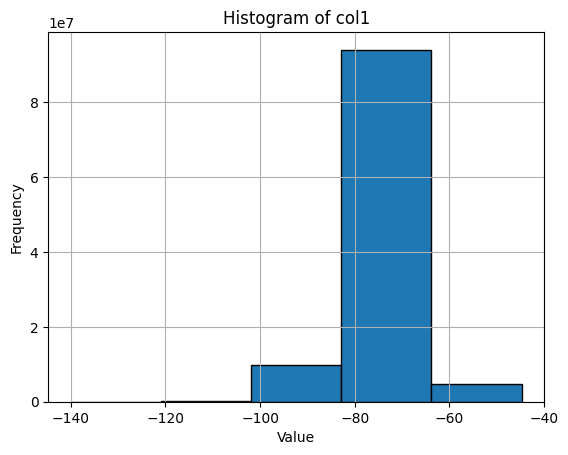

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
 

# Plot histogram of 'col1'
rfp_output['max_rf_signal_strength_dbm'].hist(bins=5, edgecolor='black')

# Add titles and labels
plt.title('Histogram of col1')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show plot
plt.show()


In [5]:
sample =  pd.read_sql(
    f"select * from chicago_rfp_10m_test_033W",
    con,) 

In [6]:
def assess_signal_quality(signal_level):
    if signal_level >= -60:
        return "Excellent"
    elif -80 <= signal_level < -60:
        return "Good"
    elif -100 <= signal_level < -80:
        return "Fair"
    else:
        return "Poor"


In [7]:
sample['quality'] = sample['max_rf_signal_strength_dbm'].apply(assess_signal_quality)
sample

,x,y,elevation_amsl_meters,rf_source_id,max_rf_signal_strength_dbm,quality
0,-87.421302,41.641103,0.0000,CHCHI00946A_n71_G_2,-77.423041,Good
1,-87.730348,41.638316,0.0000,CHCHI00401A_n71_G_2,-67.047666,Good
2,-87.675605,41.638855,2.7432,CHCHI00638A_n71_G_2,-68.423612,Good
3,-87.680549,41.638675,0.0000,CHCHI00638A_n71_G_2,-61.174213,Good
4,-87.473754,41.637596,3.3528,CHCHI00430A_n71_G_3,-93.469237,Fair
...,...,...,...,...,...,...
9783566,-87.586496,41.864431,0.0000,CHCHI00875A_n71_G_1,-79.376436,Good
9783567,-87.819457,41.856969,0.0000,CHCHI00661A_n71_G_1,-69.534054,Good
9783568,-87.896507,41.864161,0.0000,CHCHI00923A_n71_G_1,-73.529937,Good
9783569,-87.789191,41.867128,0.0000,CHCHI00232A_n71_G_2,-71.365155,Good


In [8]:
#initialization
def load_dataframe_to_table(connection, table_name, dataframe):
    connection.load_table_columnar(table_name, dataframe)

#load_dataframe_to_table(con, 'RFP_10m_10k_Output_agg' , result)
sample.max()

x                                      -87.408882
y                                       41.937346
elevation_amsl_meters                    132.8928
rf_source_id                  CHCHI02006A_n71_G_3
max_rf_signal_strength_dbm             -44.754744
quality                                      Poor
dtype: object

In [9]:
sample.min()

x                                      -87.904706
y                                       41.637596
elevation_amsl_meters                         0.0
rf_source_id                  CHCHI00182A_n71_G_1
max_rf_signal_strength_dbm            -139.999085
quality                                 Excellent
dtype: object

In [10]:
clutter  =  pd.read_sql("""select * from chicago_10m_clutter_ClassType_DSM_NoNull where 
                  raster_lon BETWEEN -87.904706 AND -87.408882 AND
                  raster_lat BETWEEN 41.637596 AND 41.937346""",    con,) 
clutter

,raster_lon,raster_lat,band_1_1,band_1_2,attenuation,attenuation_v2
0,-87.831067,41.937087,10,11,1.1,0.20
1,-87.831429,41.937084,10,11,1.1,0.20
2,-87.830946,41.937087,10,11,1.1,0.20
3,-87.831549,41.937083,10,11,1.1,0.20
4,-87.828896,41.937102,18,16,1.7,0.35
...,...,...,...,...,...,...
13712023,-87.439881,41.639139,5,0,0.8,0.15
13712024,-87.761778,41.638178,8,5,1.4,0.30
13712025,-87.438080,41.639146,6,15,1.5,0.30
13712026,-87.814975,41.638713,10,4,1.1,0.20


In [11]:
geometry_clutter = gpd.points_from_xy(clutter["raster_lat"], clutter["raster_lon"], crs="EPSG:3857")

clutter_gdf = gpd.GeoDataFrame(clutter, geometry=geometry_clutter)

In [12]:
geometry_sample = gpd.points_from_xy(sample["y"], sample["x"], crs="EPSG:3857")

sample_gdf = gpd.GeoDataFrame(sample, geometry=geometry_sample)

In [13]:
sample_gdf[:10]

,x,y,elevation_amsl_meters,rf_source_id,max_rf_signal_strength_dbm,quality,geometry
0,-87.421302,41.641103,0.000000,CHCHI00946A_n71_G_2,-77.423041,Good,POINT (41.641 -87.421)
1,-87.730348,41.638316,0.000000,CHCHI00401A_n71_G_2,-67.047666,Good,POINT (41.638 -87.730)
2,-87.675605,41.638855,2.743200,CHCHI00638A_n71_G_2,-68.423612,Good,POINT (41.639 -87.676)
3,-87.680549,41.638675,0.000000,CHCHI00638A_n71_G_2,-61.174213,Good,POINT (41.639 -87.681)
4,-87.473754,41.637596,3.352800,CHCHI00430A_n71_G_3,-93.469237,Fair,POINT (41.638 -87.474)
5,-87.579261,41.638495,4.876800,CHCHI00933A_n71_G_3,-80.082643,Fair,POINT (41.638 -87.579)
6,-87.621585,41.637686,2.438400,CHCHI00868A_n71_G_3,-63.959026,Good,POINT (41.638 -87.622)
7,-87.525362,41.638405,0.000000,CHCHI00985A_n71_G_3,-77.031681,Good,POINT (41.638 -87.525)
8,-87.606633,41.639215,0.000000,CHCHI00868A_n71_G_2,-63.181045,Good,POINT (41.639 -87.607)
9,-87.774963,41.638945,1.021719,CHCHI00401A_n71_G_3,-75.713889,Good,POINT (41.639 -87.775)


In [17]:
clutter_gdf[:10]

,raster_lon,raster_lat,band_1_1,band_1_2,attenuation,attenuation_v2,geometry
0,-87.831067,41.937087,10,11,1.1,0.20,POINT (41.937 -87.831)
1,-87.831429,41.937084,10,11,1.1,0.20,POINT (41.937 -87.831)
2,-87.830946,41.937087,10,11,1.1,0.20,POINT (41.937 -87.831)
3,-87.831549,41.937083,10,11,1.1,0.20,POINT (41.937 -87.832)
4,-87.828896,41.937102,18,16,1.7,0.35,POINT (41.937 -87.829)
5,-87.832394,41.937077,10,11,1.1,0.20,POINT (41.937 -87.832)
6,-87.829378,41.937099,25,0,1.2,0.30,POINT (41.937 -87.829)
7,-87.832273,41.937078,25,0,1.2,0.30,POINT (41.937 -87.832)
8,-87.894627,41.936339,24,0,1.1,0.25,POINT (41.936 -87.895)
9,-87.883892,41.936422,25,0,1.2,0.30,POINT (41.936 -87.884)


In [20]:
from tqdm import tqdm
import time
batch_size = 1000
no_of_batches = int(len(clutter_gdf)/batch_size)

for i in (range(10)):#no_of_batches)):
    start_time = time.time()
    start = i*batch_size
    end = min(start+batch_size,len(clutter_gdf ))
    print("started batch: ",start, " - ", end)
    joined_df = gpd.sjoin_nearest(sample_gdf, clutter_gdf[start:end], how="inner", max_distance=5)
    joined_df.geometry2 = joined_df.geometry.astype(str)
    load_dataframe_to_table(con, 'Payload_RFP_Clutter', joined_df.drop(columns=['geometry']))
#    joined_df.geometry=joined_df.geometry.astype(geometry)
    print("successfully loaded: ", len(result)," to Payload_RFP_Clutter")
    print("Time consumed: " , time.time()-start_time)
    
joined_df

started batch:  0  -  1000


KeyboardInterrupt: 

In [26]:
from tqdm import tqdm
import time
batch_size = 10
no_of_batches = int(len(clutter_gdf)/batch_size)

for i in (range(10)):#no_of_batches)):
    start_time = time.time()
    start = i*batch_size
    end = min(start+batch_size,len(clutter_gdf ))
    print("started batch: ",start, " - ", end)
    joined_df = pd.merge(sample_gdf, clutter_gdf[start:end], left_on=['x', 'y'], right_on=['raster_lon', 'raster_lat'], how='inner')
   # joined_df = gpd.sjoin_nearest(sample_gdf, clutter_gdf[start:end], how="inner", max_distance=5)
    joined_df.geometry2 = 0
    load_dataframe_to_table(con, 'Payload_RFP_Clutter', joined_df.drop(columns=['geometry_y','geometry_x']))
#    joined_df.geometry=joined_df.geometry.astype(geometry)
    print("successfully loaded: ", len(joined_df)," to Payload_RFP_Clutter")
    print("Time consumed: " , time.time()-start_time)
    break
    
joined_df

started batch:  0  -  10


KeyboardInterrupt: 

In [30]:
from tqdm import tqdm
import time
import pandas as pd
import geopandas as gpd
from concurrent.futures import ProcessPoolExecutor

def process_batch(start, end):
    start_time = time.time()
    print(f"Started batch: {start} - {end}")
    #joined_df = pd.merge(sample_gdf, clutter_gdf[start:end], left_on=['x', 'y'], right_on=['raster_lon', 'raster_lat'], how='inner')
    joined_df = gpd.sjoin_nearest(sample_gdf, clutter_gdf[start:end], how="inner", max_distance=5)

    joined_df['geometry2'] = 0
    load_dataframe_to_table(con, 'Payload_RFP_Clutter', joined_df.drop(columns=['geometry_y', 'geometry_x']))
    print(f"Successfully loaded: {len(joined_df)} to Payload_RFP_Clutter")
    print(f"Time consumed: {time.time() - start_time}")

# Ensure the columns used for joining are indexed
#sample_gdf.set_index(['x', 'y'], inplace=True)
#clutter_gdf.set_index(['raster_lon', 'raster_lat'], inplace=True)

batch_size = 100000
no_of_batches = (len(clutter_gdf) + batch_size - 1) // batch_size

with ProcessPoolExecutor() as executor:
    futures = [executor.submit(process_batch, i*batch_size, min((i+1)*batch_size, len(clutter_gdf))) for i in range(no_of_batches)]
    for future in tqdm(futures):
        future.result()

joined_df = pd.merge(sample_gdf, clutter_gdf, left_on=['x', 'y'], right_on=['raster_lon', 'raster_lat'], how='inner')
joined_df

Started batch: 0 - 100000Started batch: 300000 - 400000Started batch: 200000 - 300000

  0%|          | 0/138 [00:00<?, ?it/s]


Started batch: 100000 - 200000Started batch: 700000 - 800000Started batch: 600000 - 700000Started batch: 400000 - 500000Started batch: 500000 - 600000Started batch: 1000000 - 1100000Started batch: 800000 - 900000Started batch: 900000 - 1000000Started batch: 1100000 - 1200000
Started batch: 1200000 - 1300000Started batch: 1400000 - 1500000Started batch: 1300000 - 1400000Started batch: 1500000 - 1600000
Started batch: 1600000 - 1700000Started batch: 1700000 - 1800000Started batch: 1800000 - 1900000Started batch: 2000000 - 2100000Started batch: 1900000 - 2000000
Started batch: 2200000 - 2300000Started batch: 2100000 - 2200000

Started batch: 2300000 - 2400000Started batch: 2500000 - 2600000Started batch: 2400000 - 2500000
Started batch: 2600000 - 2700000Started batch: 2700000 - 2800000Started batch: 2800000 - 2900000
Started batch: 2900000 - 3000000Started batch: 3000000 - 3100000Started batch: 3100000 - 3200000

























  0%|          | 0/138 [1:00:18<?, ?it/s]

KeyboardInterrupt



In [38]:
sample_gdf.total_bounds

array([ 41.63759628, -87.90470645,  41.93734553, -87.40888211])

In [39]:
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
import numpy as np
import rasterio
from rasterio.features import rasterize

#sample_gdf
#clutter_gdf
# Set up the metadata
pixel_size = 0.001   # Define your pixel size
x_min, y_min, x_max, y_max = sample_gdf.total_bounds
width = int((x_max - x_min) / pixel_size)
height = int((y_max - y_min) / pixel_size)
transform = from_origin(x_min, y_max, pixel_size, pixel_size)

# Initialize an empty numpy array
raster = np.zeros((height, width), dtype=np.float32)

# Rasterize the GeoDataFrame
for _, row in sample_gdf.iterrows():
    shapes = [(row['geometry'], 1)]
    burned = rasterize(shapes, out_shape=raster.shape, transform=transform)
    raster += burned

# Write to a TIFF file
with rasterio.open(
    'output.tif',
    'w',
    driver='GTiff',
    height=raster.shape[0],
    width=raster.shape[1],
    count=1,
    dtype=raster.dtype,
    crs=gdf.crs,
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("GeoDataFrame successfully exported to TIFF")


KeyboardInterrupt: 

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
import numpy as np
import rasterio
from rasterio.features import rasterize

#sample_gdf
#clutter_gdf
# Set up the metadata
pixel_size = 0.001   # Define your pixel size
x_min, y_min, x_max, y_max = clutter_gdf.total_bounds
width = int((x_max - x_min) / pixel_size)
height = int((y_max - y_min) / pixel_size)
transform = from_origin(x_min, y_max, pixel_size, pixel_size)

# Initialize an empty numpy array
raster = np.zeros((height, width), dtype=np.float32)

# Rasterize the GeoDataFrame
for _, row in sample_gdf.iterrows():
    shapes = [(row['geometry'], 1)]
    burned = rasterize(shapes, out_shape=raster.shape, transform=transform)
    raster += burned

# Write to a TIFF file
with rasterio.open(
    'output_clutter_gdf.tif',
    'w',
    driver='GTiff',
    height=raster.shape[0],
    width=raster.shape[1],
    count=1,
    dtype=raster.dtype,
    crs=gdf.crs,
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("GeoDataFrame successfully exported to TIFF")


In [32]:
!pip install rasterio numpy

In [34]:
from rasterio.features import rasterize


In [ ]:
Payload_Chicago_Cell_Data

In [ ]:
joined_df = pd.merge(sample_gdf, batch_df, left_on=['lon', 'lat'], right_on=['raster_lon', 'raster_lat'], how='inner')


In [16]:
joined_df.dtypes

x                              float64
y                              float64
elevation_amsl_meters          float64
rf_source_id                    object
max_rf_signal_strength_dbm     float64
quality                         object
geometry                      geometry
index_right                      int64
raster_lon                     float64
raster_lat                     float64
band_1_1                         int64
band_1_2                         int64
attenuation                    float64
attenuation_v2                 float64
dtype: object

In [39]:
#with Dask parallel processing
import dask.dataframe as dd
import geopandas as gpd
from tqdm import tqdm
import time
from dask import delayed, compute
from dask.distributed import Client, LocalCluster

# Set up Dask cluster with 30 cores
cluster = LocalCluster(n_workers=10, threads_per_worker=5)
client = Client(cluster)

batch_size = 100

no_of_batches = int(len(clutter_gdf) / batch_size)

def load_dataframe_to_table(connection, table_name, dataframe):
    connection.load_table_columnar(table_name, dataframe)

# decorateds function to process a batch
@delayed

def process_batch(start, end, sample_gdf, clutter_gdf):
    start_time = time.time()
    print("Started batch: ", start, end)
    joined_df = gpd.sjoin_nearest(sample_gdf, clutter_gdf[start:end], how="inner", max_distance=5)
    print("Time consumed: ", time.time() - start_time)
  #  load_dataframe_to_table(con, 'Payload_RFP_Clutter', joined_df)
    print("successfully loaded: ", len(result)," to Payload_RFP_Clutter")
    return joined_df
    
#def process_batch(start, end):
#    start_time = time.time()
#    print("Started batch: ", start, end)
#    joined_df = gpd.sjoin_nearest(sample_gdf, clutter_gdf[start:end], how="inner", max_distance=5)
#    print("Time consumed: ", time.time() - start_time)
#    load_dataframe_to_table(con, 'Payload_RFP_Clutter', joined_df)
#    print("successfully loaded: ", len(result)," to Payload_RFP_Clutter")
#    return joined_df

# List to hold delayed objects
results = []

for i in tqdm(range(50)):#no_of_batches)):
    start = i * batch_size
    end = min(start + batch_size, len(clutter_gdf))
    result = process_batch(start, end,sample_gdf, clutter_gdf )
    #print(result)
    results.append(result)

results = dd.compute(*results)

final_df = gpd.GeoDataFrame(pd.concat(results, ignore_index=True))
client.close()

final_df

100%|██████████| 50/50 [00:00<00:00, 5526.38it/s]
Exception ignored in: <function Connection.__del__ at 0x7cc05c5e1ee0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/heavydb/connection.py", line 335, in __del__
    self.close()
  File "/opt/conda/lib/python3.11/site-packages/heavydb/connection.py", line 351, in close
    self._client.disconnect(self._session)
  File "/opt/conda/lib/python3.11/site-packages/heavydb/thrift/Heavy.py", line 1115, in disconnect
    self.recv_disconnect()
  File "/opt/conda/lib/python3.11/site-packages/heavydb/thrift/Heavy.py", line 1127, in recv_disconnect
    (fname, mtype, rseqid) = iprot.readMessageBegin()
                             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/thrift/protocol/TBinaryProtocol.py", line 138, in readMessageBegin
    raise TProtocolException(
thrift.protocol.TProtocol.TProtocolException: Bad version in readMessageBegin: -1068111250
2024-07-11 17:49:46,254 - d

In [ ]:
final_df

self._selector.poll(timeout, max_ev)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/asyncio/runners.py", line 157, in _on_sigint
    raise KeyboardInterrupt()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/distributed/utils.py", line 838, in wrapper
    return await func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/distributed/worker.py", line 1558, in close
    await r.close_gracefully(reason=reason)
  File "/opt/conda/lib/python3.11/site-packages/distributed/core.py", line 1395, in send_recv_from_rpc
    comm = await self.pool.connect(self.addr)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/distributed/core.py", line 1623, in connect
    return await self._connect(addr=addr, timeout=timeout)
           ^^^^^^^^^^^

In [31]:
joined_df.columns

Index(['x', 'y', 'elevation_amsl_meters', 'rf_source_id',
       'max_rf_signal_strength_dbm', 'quality', 'geometry', 'index_right',
       'raster_lon', 'raster_lat', 'band_1_1', 'band_1_2', 'attenuation',
       'attenuation_v2'],
      dtype='object')

In [32]:
final_df.columns

Index(['x', 'y', 'elevation_amsl_meters', 'rf_source_id',
       'max_rf_signal_strength_dbm', 'quality', 'geometry', 'index_right',
       'raster_lon', 'raster_lat', 'band_1_1', 'band_1_2', 'attenuation',
       'attenuation_v2'],
      dtype='object')

In [26]:
final_df = gpd.GeoDataFrame(pd.concat(results, ignore_index=True))

ValueError: No objects to concatenate

In [ ]:
joined_df = gpd.sjoin_nearest(sample_gdf, clutter_gdf, how="inner", max_distance=5)
joined_df

In [22]:
!pip install dask[complete]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 102.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.7/241.7 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 4.4 MB/s eta 0:00:00
